#Libraries

In [1]:
! git clone https://github.com/neuromatch/ComputationThruDynamicsBenchmark
%cd ComputationThruDynamicsBenchmark
! pip install -e .

Cloning into 'ComputationThruDynamicsBenchmark'...
remote: Enumerating objects: 3359, done.
remote: Counting objects: 100% (585/585), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 3359 (delta 519), reused 501 (delta 501), pack-reused 2774 (from 1)
Receiving objects: 100% (3359/3359), 296.08 MiB | 19.70 MiB/s, done.
Resolving deltas: 100% (1883/1883), done.
Updating files: 100% (262/262), done.
/content/ComputationThruDynamicsBenchmark
Obtaining file:///content/ComputationThruDynamicsBenchmark
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.

In [2]:
!pip uninstall -y torchaudio torchvision

Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124


In [3]:
%cd /content/ComputationThruDynamicsBenchmark/
envStr = """HOME_DIR=/content/ComputationThruDynamicsBenchmark/
# #Don't change these
# TRAIN_INPUT_FILE=train_input.h5\nEVAL_INPUT_FILE=eval_input.h5
# EVAL_TARGET_FILE=eval_target.h5
# """

/content/ComputationThruDynamicsBenchmark


In [4]:
with open('.env','w') as f:
  f.write(envStr)

In [5]:
import os
os.chdir('/content/ComputationThruDynamicsBenchmark')
print("Current directory:", os.getcwd())
print("Directory contents:", os.listdir("."))

Current directory: /content/ComputationThruDynamicsBenchmark
Directory contents: ['README.md', '.gitmodules', '.pre-commit-config.yaml', '.git', 'ctd.egg-info', 'examples', '.gitignore', '.env', '.gitattributes', 'ctd', 'requirements.txt', 'pretrained', 'setup.py', 'utils.py', 'libs']


In [6]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# MotorNet & CTD
from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
from ctd.task_modeling.task_env.task_env import RandomTarget

#Load Model Set up

##Upload the Model and datamodule files here

In [7]:
from google.colab import files
uploaded = files.upload()

Saving datamodule_randomtarget.pkl to datamodule_randomtarget (1).pkl
Saving model (3).pkl to model (3) (1).pkl


##change the model's and datamodule's pickle file name to match the uploaded files.

In [8]:
# Load model
with open("model (3).pkl", "rb") as f:
    wrapper = pickle.load(f)         # This is your TaskTrainedWrapper
    model = wrapper.model

with open("datamodule_randomtarget.pkl", "rb") as f:
    datamodule = pickle.load(f)

In [9]:
# Recreate the effector and muscle used in training
effector = RigidTendonArm26(muscle=MujocoHillMuscle())

# Reconstruct the reaching task environment
env = wrapper.task_env

In [10]:
ctx_value = torch.tensor(env.context_inputs.sample(), dtype=torch.float32)  # shape: (ctx_dim,)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GRU_RNN(
  (cell): GRUCell(17, 128)
  (readout): Linear(in_features=128, out_features=6, bias=True)
)

#Nomal Conditions - No force-Field

In [11]:
def rollout_trajectories(model, env, device="cpu", n_trials=5, max_steps=100):
    """
    Rollout trajectories in the RandomTarget environment using the trained RNN model.
    """
    model.eval()
    hand_trajs = []
    target_pos = []

    for _ in range(n_trials):
        # Reset environment
        obs_raw = env.reset()
        obs = obs_raw[0].squeeze(0).to(device) if isinstance(obs_raw, tuple) and isinstance(obs_raw[0], torch.Tensor) else torch.tensor(obs_raw[0], dtype=torch.float32).to(device)

        # Sample context vector
        ctx = env.context_inputs.sample()
        ctx = torch.tensor(ctx, dtype=torch.float32).to(device)

        # Initialize RNN hidden state: shape (1, hidden_size)
        h = torch.zeros(1, model.cell.hidden_size, device=device)

        traj = []
        steps = 0
        terminated = False
        truncated = False

        while not (terminated or truncated) and steps < max_steps:
            x = torch.cat([obs, ctx], dim=-1).unsqueeze(0)  # Shape: (1, input_size)
            h = model.cell(x, h)
            action = model.readout(h)

            # Step environment
            obs_next, reward, terminated, truncated, info = env.step(action.detach().cpu().numpy())
            obs = obs_next.squeeze(0).to(device) if isinstance(obs_next, torch.Tensor) else torch.tensor(obs_next, dtype=torch.float32).to(device)

            # Record fingertip position
            fingertip = info['states']['fingertip'].squeeze().cpu().numpy()
            traj.append(fingertip)

            steps += 1
            if terminated:
                break

        hand_trajs.append(np.array(traj))

        # Get target position
        if 'goal' in info and isinstance(info['goal'], torch.Tensor):
            target_pos.append(info['goal'].squeeze().cpu().numpy())
        else:
            target_pos.append(info['states']['cartesian'][0, :2].cpu().numpy())

    return hand_trajs, target_pos

In [12]:
def plot_trajectories(hand_trajs, target_pos):
    """
    Plot each trajectory and its corresponding target position with consistent coloring and labels.
    """
    colors = cm.get_cmap('tab10', len(hand_trajs))

    plt.figure(figsize=(10, 10))

    for i, (traj, target) in enumerate(zip(hand_trajs, target_pos)):
        traj = np.array(traj)
        color = colors(i)

        # Plot hand trajectory
        plt.plot(traj[:, 0], traj[:, 1], color=color, label=f'Traj {i+1}')

        # Plot endpoint of trajectory
        plt.plot(traj[-1, 0], traj[-1, 1], 'o', color=color)

        # Plot target position
        plt.plot(target[0], target[1], '*', markersize=12, color=color)
        plt.text(target[0], target[1], f'T{i+1}', fontsize=9, ha='center', va='bottom', color=color)

    plt.title("Hand Trajectories and Targets")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-12-1114459611.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(hand_trajs))


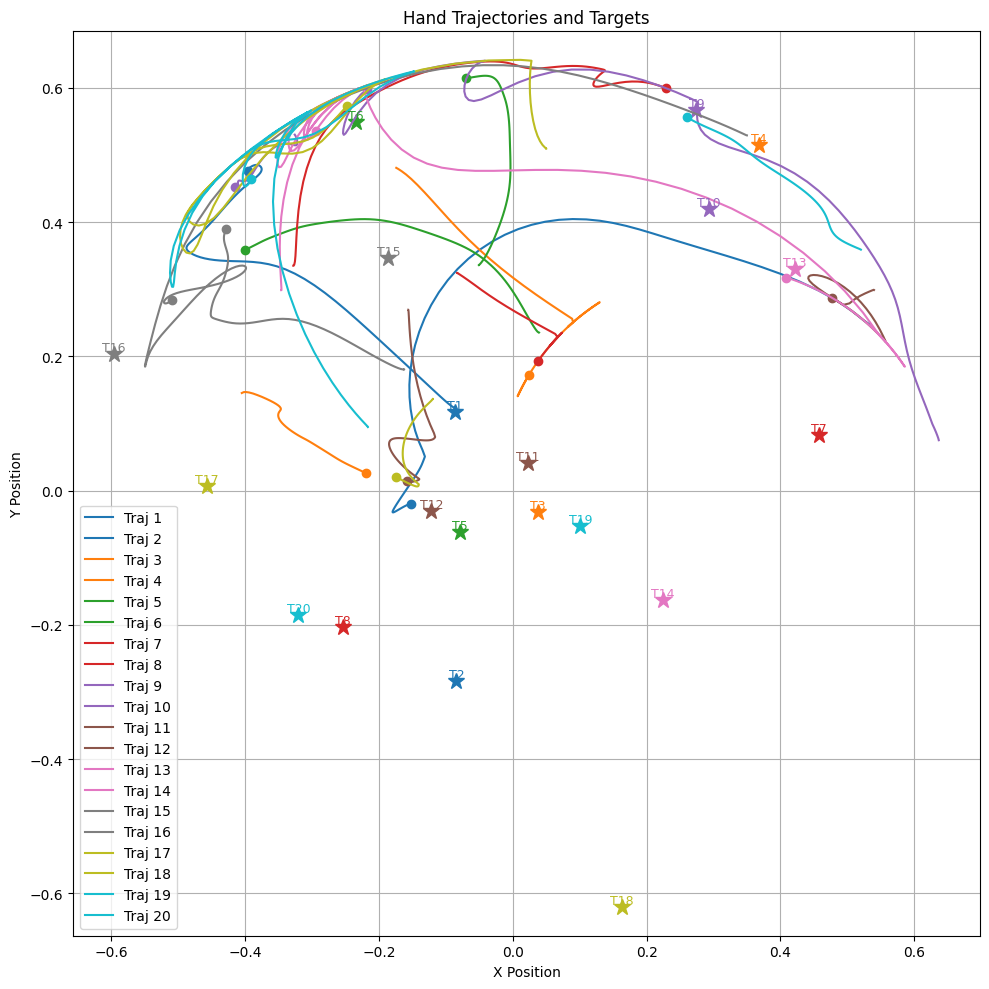

In [13]:
hand_trajs, target_pos = rollout_trajectories(model, wrapper.task_env, device="cpu", n_trials=20)
plot_trajectories(hand_trajs, target_pos)

In [14]:
def compute_final_errors(hand_trajs, target_pos):
    """
    Compute Euclidean distance between the final point of each hand trajectory and its target.
    """
    errors = []
    for traj, target in zip(hand_trajs, target_pos):
        traj = np.array(traj)
        final_point = traj[-1]  # last hand position
        error = np.linalg.norm(final_point - target)
        errors.append(error)
    return errors

In [15]:
def plot_errors(errors):
    """
    Plot the Euclidean error for each trial as a bar chart.
    """
    trials = np.arange(1, len(errors)+1)

    plt.figure(figsize=(8, 4))
    bars = plt.bar(trials, errors, color='skyblue', edgecolor='black')

    # Annotate bars
    for bar, err in zip(bars, errors):
        plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), f'{err:.2f}',
                 ha='center', va='bottom', fontsize=9)

    plt.title("Final Distance Error per Trial")
    plt.xlabel("Trial")
    plt.ylabel("Distance to Target")
    plt.ylim(0, max(errors)*1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(trials)
    plt.tight_layout()
    plt.show()

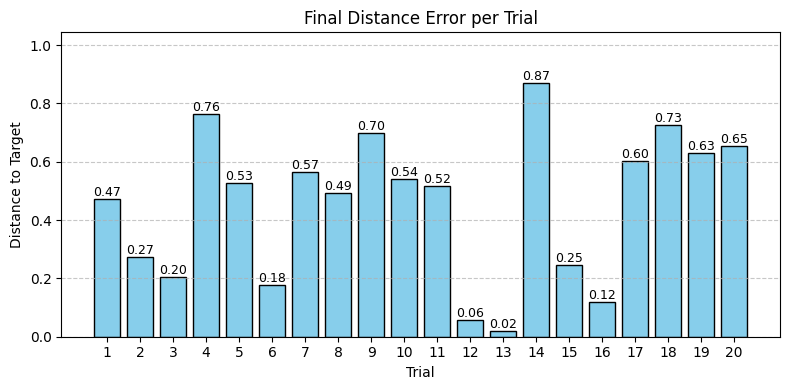

In [16]:
errors = compute_final_errors(hand_trajs, target_pos)
plot_errors(errors)

In [17]:
print(f"Mean Error: {np.mean(errors):.3f}")
print(f"Median Error: {np.median(errors):.3f}")
print(f"Max Error: {np.max(errors):.3f}")
print(f"Min Error: {np.min(errors):.3f}")

Mean Error: 0.458
Median Error: 0.523
Max Error: 0.870
Min Error: 0.018


In [18]:
def compute_path_lengths(hand_trajs):
    """
    Compute total length of each trajectory (sum of segment distances).
    """
    lengths = []
    for traj in hand_trajs:
        traj = np.array(traj)
        diffs = np.diff(traj, axis=0)
        dists = np.linalg.norm(diffs, axis=1)
        total_length = np.sum(dists)
        lengths.append(total_length)
    return lengths

In [19]:
def plot_path_lengths(lengths):
    trials = np.arange(1, len(lengths)+1)

    plt.figure(figsize=(8, 4))
    bars = plt.bar(trials, lengths, color='mediumseagreen', edgecolor='black')

    for bar, val in zip(bars, lengths):
        plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), f'{val:.2f}',
                 ha='center', va='bottom', fontsize=9)

    plt.title("Trajectory Smoothness (Total Path Length)")
    plt.xlabel("Trial")
    plt.ylabel("Total Length")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(trials)
    plt.tight_layout()
    plt.show()

In [20]:
def compute_success_rate(errors, threshold=0.05):
    """
    Calculate percentage of trials with final error below threshold (5 cm).
    """
    successes = [err < threshold for err in errors]
    rate = 100 * np.mean(successes)
    return rate, successes

In [21]:
def plot_success_bars(successes):
    trials = np.arange(1, len(successes)+1)
    colors = ['green' if s else 'red' for s in successes]

    plt.figure(figsize=(8, 2.5))
    bars = plt.bar(trials, [1]*len(successes), color=colors, edgecolor='black')

    plt.title("Success per Trial (Green = <5cm to Target)")
    plt.xlabel("Trial")
    plt.yticks([])  # Hide y-axis
    plt.xticks(trials)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

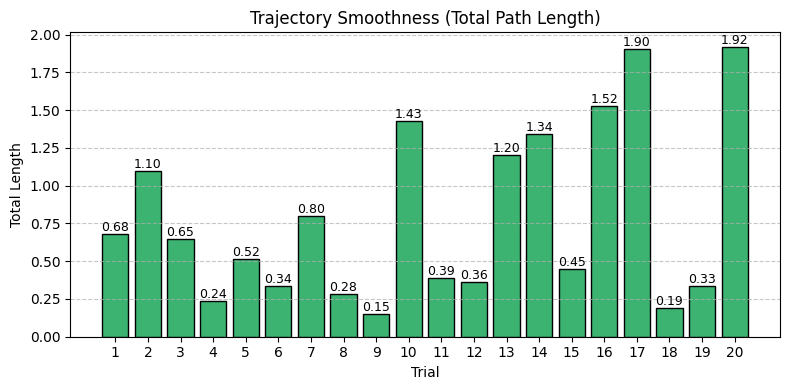

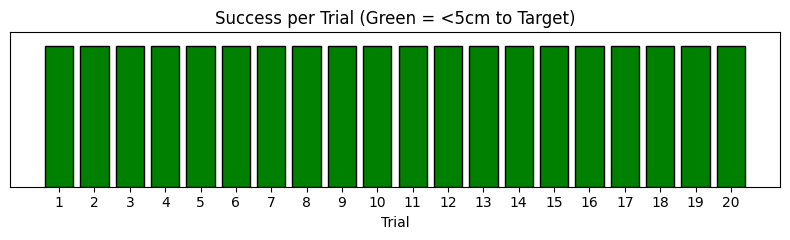

Success Rate (<1cm): 100.0% (20/20 trials)


In [22]:
lengths = compute_path_lengths(hand_trajs)
plot_path_lengths(lengths)

# Success rate
success_rate, success_bools = compute_success_rate(errors, threshold=1)
plot_success_bars(success_bools)

print(f"Success Rate (<1cm): {success_rate:.1f}% ({sum(success_bools)}/{len(success_bools)} trials)")

#1N left Force-Field

In [23]:
def rollout_with_force_field(model, env, device="cpu", force=np.array([-1.0, 0.0]), n_trials=5, max_steps=100):
    """
    Rollout trajectories in the RandomTarget environment using the trained RNN model
    under a fixed force field perturbation, applied to both the fingertip and joint state.
    """
    model.eval()
    hand_trajs = []
    target_pos = []
    mse_errors = []

    for _ in range(n_trials):
        # Reset environment
        obs_raw = env.reset()
        obs = obs_raw[0].squeeze(0).to(device) if isinstance(obs_raw, tuple) and isinstance(obs_raw[0], torch.Tensor) else torch.tensor(obs_raw[0], dtype=torch.float32).to(device)
        info = obs_raw[1] if isinstance(obs_raw, tuple) and len(obs_raw) > 1 else {}

        # Sample context vector
        ctx = env.context_inputs.sample()
        ctx = torch.tensor(ctx, dtype=torch.float32).to(device)

        # Initialize RNN hidden state
        h = torch.zeros(1, model.cell.hidden_size, device=device)

        traj = []
        steps = 0
        terminated = False
        truncated = False

        while not (terminated or truncated) and steps < max_steps:
            # Apply force perturbation
            perturb = torch.tensor(force * 0.01, dtype=torch.float32).to(device)

            if 'states' in info:
                if 'fingertip' in info['states']:
                    fingertip = info['states']['fingertip'].squeeze(0).to(device)
                    obs[:2] = fingertip + perturb  # Perturb fingertip (obs[0:2])

                if 'joint' in info['states']:
                    joint = info['states']['joint'].squeeze(0).to(device)
                    joint[:2] += perturb  # Only apply force to X, Y joints
                    obs[2:6] = joint  # Replace joint portion (obs[2:6])

            # Forward pass
            x = torch.cat([obs, ctx], dim=-1).unsqueeze(0)
            h = model.cell(x, h)
            action = model.readout(h)

            # Step environment
            obs_next, reward, terminated, truncated, info = env.step(action.detach().cpu().numpy())
            obs = obs_next.squeeze(0).to(device) if isinstance(obs_next, torch.Tensor) else torch.tensor(obs_next, dtype=torch.float32).to(device)

            # Record real fingertip for trajectory tracking
            if 'states' in info and 'fingertip' in info['states']:
                fingertip_real = info['states']['fingertip'].squeeze().cpu().numpy()
                traj.append(fingertip_real)

            steps += 1
            if terminated:
                break

        hand_trajs.append(np.array(traj))

        # Get target position
        if 'goal' in info and isinstance(info['goal'], torch.Tensor):
            target = info['goal'].squeeze().cpu().numpy()
        else:
            target = info['states']['cartesian'][0, :2].cpu().numpy()
        target_pos.append(target)

        mse = np.mean((np.array(traj) - target)**2)
        mse_errors.append(mse)

    avg_mse = np.mean(mse_errors)
    return hand_trajs, target_pos, avg_mse

Force Field MSE: 0.2460


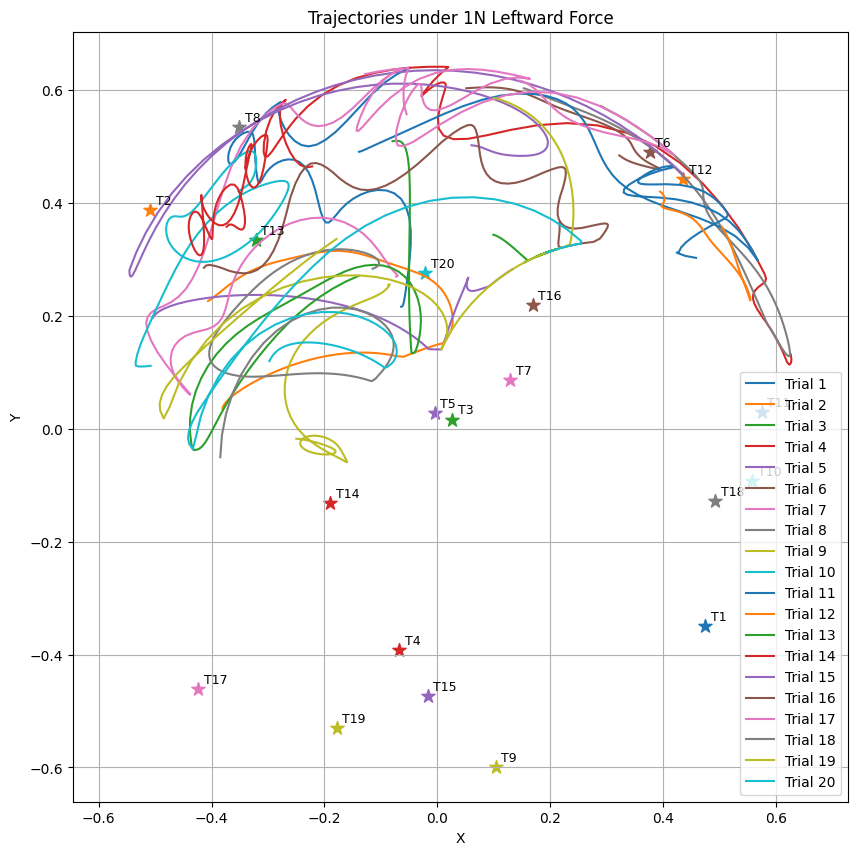

In [24]:
hand_trajs_ff, target_pos_ff, mse_ff = rollout_with_force_field(model, wrapper.task_env,force=np.array([-1.0, 0.0]), device="cpu", n_trials=20)

#print(f"Original MSE: {mse_orig:.4f}")
print(f"Force Field MSE: {mse_ff:.4f}")

# Plot
def plot_trajectories_with_labels(trajs, targets, title="Hand Trajectories vs Targets"):
    plt.figure(figsize=(10, 10))
    for i, traj in enumerate(trajs):
        plt.plot(traj[:, 0], traj[:, 1], label=f"Trial {i+1}")
        plt.scatter(targets[i][0], targets[i][1], s=100, marker='*')
        plt.text(targets[i][0] + 0.01, targets[i][1] + 0.01, f"T{i+1}", fontsize=9)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

plot_trajectories_with_labels(hand_trajs_ff, target_pos_ff, title="Trajectories under 1N Leftward Force")

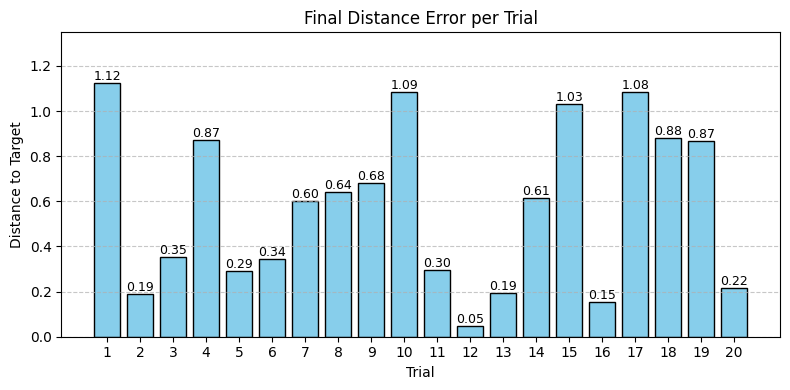

In [25]:
errors_ff = compute_final_errors(hand_trajs_ff, target_pos_ff)
plot_errors(errors_ff)

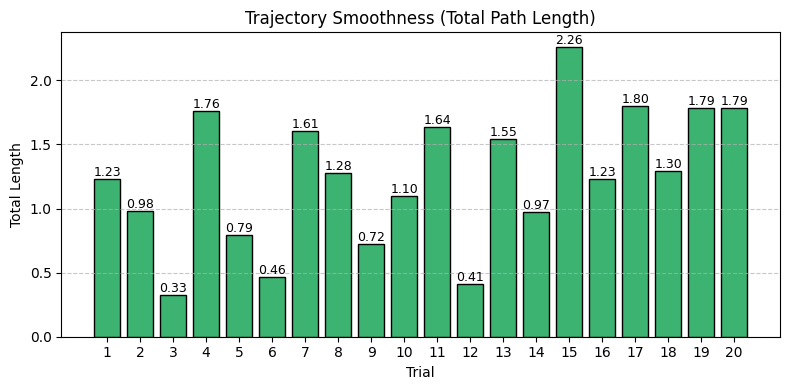

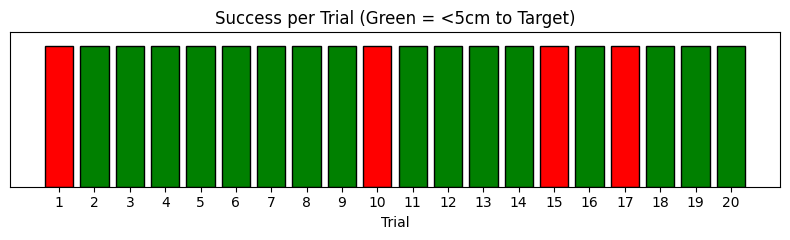

Success Rate fo 1N left force-field (<1cm): 100.0% (16/20 trials)


In [26]:
lengths_ff = compute_path_lengths(hand_trajs_ff)
plot_path_lengths(lengths_ff)

# Success rate
success_rate_ff, success_bools_ff = compute_success_rate(errors_ff, threshold=1)
plot_success_bars(success_bools_ff)

print(f"Success Rate fo 1N left force-field (<1cm): {success_rate:.1f}% ({sum(success_bools_ff)}/{len(success_bools_ff)} trials)")

In [27]:
print(wrapper.task_env.reset())

(tensor([[-0.1156,  0.5093,  0.9309,  1.0961,  0.9819,  0.8189,  0.8246,  0.7991,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]), {'states': {'joint': tensor([[1.1461, 1.2422, 0.0000, 0.0000]]), 'cartesian': tensor([[-0.1156,  0.5093, -0.0000, -0.0000]]), 'muscle': tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.2474e-01, 1.5346e-01, 9.0337e-02, 7.6160e-02, 1.1297e-01,
          1.0149e-01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 1.0694e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [9.6397e-01, 9.4866e-01, 9.9739e-01, 8.3542e-01, 8.4510e-01,
          7.9460e-01],
         [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.2908e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]]]), 'geometry': tensor([[[ 0.1637,  0.2195,  0.2623,  0.2632,  0.3

#Test Untrained model

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def compare_initial_vs_trained(model_trained, task_env, n_trials=5, max_steps=100, device="cpu"):
    # Make deep copies of the environment so rollouts don’t interfere
    import copy
    env1 = copy.deepcopy(task_env)
    env2 = copy.deepcopy(task_env)

    # Create the same architecture as the trained model for the initial model
    model_init = type(model_trained)(latent_size=model_trained.latent_size)
    model_init.init_model(
        input_size=task_env.observation_space.shape[0] + task_env.context_inputs.shape[0],
        output_size=task_env.action_space.shape[0]
    )
    model_init.to(device)
    model_trained.to(device)

    # Run rollouts
    def rollout(model, env):
        model.eval()
        hand_trajs = []
        target_pos = []

        for _ in range(n_trials):
            obs_raw = env.reset()
            obs = torch.tensor(obs_raw[0], dtype=torch.float32).squeeze(0).to(device)
            ctx = env.context_inputs.sample()
            ctx = torch.tensor(ctx, dtype=torch.float32).to(device)
            h = torch.zeros(1, model.cell.hidden_size, device=device)

            traj = []
            steps = 0
            terminated = False
            truncated = False

            while not (terminated or truncated) and steps < max_steps:
                x = torch.cat([obs, ctx], dim=-1).unsqueeze(0)
                h = model.cell(x, h)
                action = model.readout(h)
                obs_next, reward, terminated, truncated, info = env.step(action.detach().cpu().numpy())
                obs = torch.tensor(obs_next, dtype=torch.float32).squeeze(0).to(device)

                fingertip = info['states']['fingertip'].squeeze().cpu().numpy()
                traj.append(fingertip)

                steps += 1
                if terminated:
                    break

            hand_trajs.append(np.array(traj))
            target_pos.append(info['goal'].squeeze().cpu().numpy())

        return hand_trajs, target_pos

    # Rollouts
    trajs_init, targets_init = rollout(model_init, env1)
    trajs_trained, targets_trained = rollout(model_trained, env2)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    for traj, tgt in zip(trajs_init, targets_init):
        axes[0].plot(traj[:, 0], traj[:, 1], label='trajectory')
        axes[0].scatter(tgt[0], tgt[1], marker='x', label='target')
    axes[0].set_title("Initial (Untrained) Model")
    axes[0].legend()

    for traj, tgt in zip(trajs_trained, targets_trained):
        axes[1].plot(traj[:, 0], traj[:, 1], label='trajectory')
        axes[1].scatter(tgt[0], tgt[1], marker='x', label='target')
    axes[1].set_title("Trained Model")
    axes[1].legend()

    plt.suptitle(f"Trajectory Comparison ({n_trials} Trials)")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-28-935964527.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs_raw[0], dtype=torch.float32).squeeze(0).to(device)
/tmp/ipython-input-28-935964527.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs_next, dtype=torch.float32).squeeze(0).to(device)


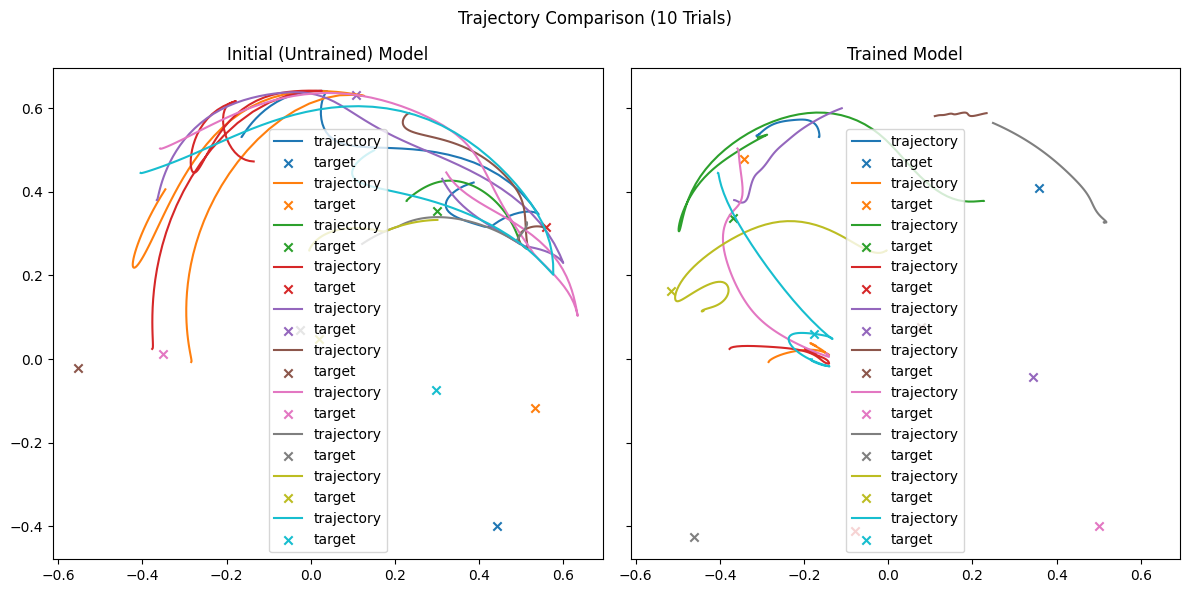

In [29]:
compare_initial_vs_trained(model_trained=model, task_env=env, n_trials=10)